# OpFlow domain-decomposed 2D TGRF experiment

### load necessary libraries

In [22]:
from __future__ import division

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic
import torch
import torch.nn as nn 
from math import pi 
import torch.nn.functional as F
from torch.nn.parameter import Parameter

from torch.distributions.multivariate_normal import MultivariateNormal
import math
from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate
import pylab as plt
import statsmodels.api as sm
#from random_fields import *

import timeit


from sklearn.gaussian_process.kernels import Matern, RBF
from sklearn.gaussian_process import GaussianProcessRegressor
import statsmodels.api as sm

In [23]:
import os

#os.environ['CUDA_VISIBLE_DEVICES'] = "5"
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
torch.set_num_threads(1)

In [3]:
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor

def GaussianProcess_2C(ndim, length_scale, nu, n_samples, return_kernel=False, nchannel = 1):
    x = np.linspace(0, 1, ndim)
    y = np.linspace(0, 1, ndim)
    XX, YY = np.meshgrid(x, y)
    XX = XX.reshape(-1, 1)
    YY = YY.reshape(-1, 1)
    X = np.concatenate([XX, YY], axis=1)
    print(X.shape)
    kernel = 1.0 * Matern(length_scale=length_scale, length_scale_bounds=(1e-1, 10.0), nu=nu)
    gpr_model = GaussianProcessRegressor(kernel=kernel)
    y_mean, y_std = gpr_model.predict(X, return_std=True)
    if nchannel == 1:
        y_samples = gpr_model.sample_y(X, n_samples)[:,:,np.newaxis]
    else:
        arr = []
        a = gpr_model.sample_y(X, n_samples*nchannel)[:,:,None]
        for i in range(nchannel):
            arr.append(a[:,n_samples*i:n_samples*(i+1),:])
        y_samples = np.concatenate(arr, axis=-1)
        assert(y_samples.shape == np.zeros([ndim*ndim, n_samples, nchannel]).shape)
        
    if return_kernel:
        return torch.tensor(y_samples), kernel(X), gpr_model
    else:
        return torch.tensor(y_samples)
    
def compute_acovf(z):
    # z shape : [n, ndim, ndim]
    res = z.shape[-1]
    z_hat = torch.fft.rfft2(z)
    acf = torch.fft.irfft2(torch.conj(z_hat) * z_hat)
    acf = torch.fft.fftshift(acf).mean(dim=0) / z[0].numel() # ndim*ndim
    acf_r = acf.view(-1).cpu().detach().numpy()
    lags_x, lags_y = torch.meshgrid(torch.arange(res) - res//2, torch.arange(res) - res//2)
    lags_r = torch.sqrt(lags_x**2 + lags_y**2).view(-1).cpu().detach().numpy()

    idx = np.argsort(lags_r)
    lags_r = lags_r[idx]
    acf_r = acf_r[idx]

    bin_means, bin_edges, binnumber = binned_statistic(lags_r, acf_r, 'mean', bins=np.linspace(0.0, res, 50))
    return bin_edges[:-1], bin_means

### dataset parameters and preparation

In [4]:
ntrain = 20000
#ntrain = 200
nchannel = 1
ndim = 64
batch_size = 256

length_scale_x = 0.5
nu_x = 1.5

length_scale_z = 0.1
nu_z = 0.5

lb = -2
ub = 2

In [5]:
start = timeit.default_timer() 

In [6]:
# Truncated 
def truncatedGRF(ndim, length_scale_x, nu_x, ntrain, lb=-4, ub=4, nchannel=1):
    # temp_x_train = [ndim*ndim, ntrain, nchannel=1]

    x = np.linspace(0, 1, ndim)
    y = np.linspace(0, 1, ndim)
    XX, YY = np.meshgrid(x, y)
    XX = XX.reshape(-1, 1)
    YY = YY.reshape(-1, 1)
    X = np.concatenate([XX, YY], axis=1)
    print(X.shape)
    kernel = 1.0 * Matern(length_scale=length_scale_x, length_scale_bounds=(1e-1, 10.0), nu=nu_x)
    gpr_model = GaussianProcessRegressor(kernel=kernel)
    #y_mean, y_std = gpr_model.predict(X, return_std=True)

    x_train = []
    samples = 0
    
    while samples < ntrain:
        temp_x_train = torch.Tensor(gpr_model.sample_y(X, ntrain, random_state=None)[:,:,np.newaxis])
        # 
        logic_value = (temp_x_train <= ub) & (temp_x_train >= lb)
        pass_id = torch.all(logic_value, axis=0)
        
        n_generated = temp_x_train[:,pass_id].shape[1]
        if n_generated > 0:
            samples += n_generated
            
            x_train.append(temp_x_train[:, pass_id])
            print("finished {}/{} ".format(samples, ntrain))
            
    # concatenate
    x_train = torch.cat(x_train, dim=1)
    x_train = x_train[:,:ntrain]
    return x_train[:,:,None]

Starting up. Generate TGRF samples
(4096, 2)
finished 9626/20000 
finished 19077/20000 
finished 28672/20000 
(4096, 2)


/home/yshi5/miniconda3/envs/Pytorch/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755849709/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


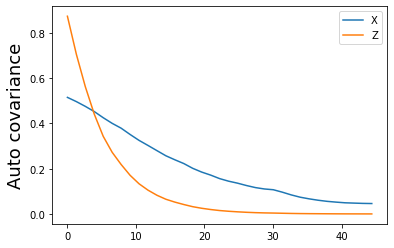

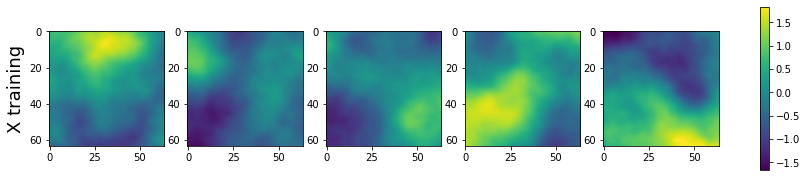

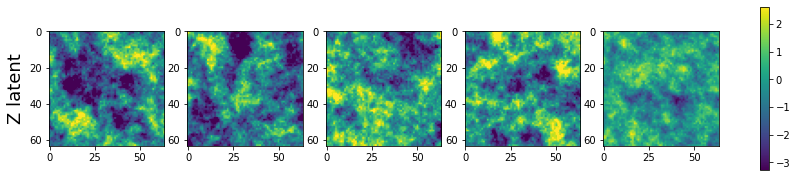

In [7]:
print("Starting up. Generate TGRF samples")
import statsmodels.api as sm

np.random.seed(22)
#x_train = np.load('./datasets/TruncatedGRF/x_train_1_2.npy')
#x_train = torch.Tensor(x_train)
x_train = truncatedGRF(ndim, length_scale_x, nu_x, ntrain, lb=lb, ub=ub, nchannel=1)
x_train = x_train.float().permute([1,0,2]).reshape(-1, ndim, ndim, nchannel)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train), batch_size=batch_size, shuffle=True,pin_memory=False)


## calculate the autocov 
z_train, kernel, z_gpmodel = GaussianProcess_2C(ndim, length_scale_z, nu_z, 2*ntrain, return_kernel=True, nchannel=nchannel)
z_train = z_train.float().permute([1,0,2]).reshape(-1, ndim, ndim, nchannel)
z_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(z_train), batch_size=batch_size, shuffle=True,pin_memory=False)

## calculate the statistics 
x_distance, x_acovf_mean = compute_acovf(x_train[:,:,:,0])
z_distance, z_acovf_mean = compute_acovf(z_train[:,:,:,0])

plt.plot(x_distance, x_acovf_mean, label='X')
plt.plot(z_distance, z_acovf_mean, label='Z')
plt.legend()
plt.ylabel("Auto covariance", fontsize=18)

fig, ax = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    x = x_train[i,:,:,0].squeeze()
    ax[i].imshow(x, vmin=-2, vmax=2)
    if i == 0:
        ax[i].set_ylabel('X training', fontsize=18)

#cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
bar = ax[4].imshow(x)
fig.colorbar(bar, ax=ax)
#plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,3))    
for i in range(5):
    z = z_train[i,:,:,0].squeeze()
    ax[i].imshow(z, vmin=-2, vmax=2)
    if i == 0:
        ax[i].set_ylabel('Z latent', fontsize=18)
              
bar = ax[4].imshow(z)
fig.colorbar(bar, ax=ax)

In [8]:
# save the data 
#np.save('./datasets/TruncatedGRF/x_train_1_2.npy', x_train.numpy())
#end = timeit.default_timer() 
#print(end - start)

## Model

In [24]:
def kernel_loc(in_chan=2, up_dim=32):
    """
        Kernel network apply on grid
    """
    layers = nn.Sequential(
                nn.Linear(in_chan, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, 1, bias=False)
            )
    return layers

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, dim1, dim2,modes1 = None, modes2 = None):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """
        in_channels = int(in_channels)
        out_channels = int(out_channels)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dim1 = dim1 #output dimensions
        self.dim2 = dim2
        if modes1 is not None:
            self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
            self.modes2 = modes2
        else:
            self.modes1 = dim1//2-1 #if not given take the highest number of modes can be taken
            self.modes2 = dim2//2 
        self.scale = (1 / (2*in_channels))**(1.0/2.0)
        self.weights1 = nn.Parameter(self.scale * (torch.randn(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)))
        self.weights2 = nn.Parameter(self.scale * (torch.randn(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x, dim1 = None,dim2 = None):
        if dim1 is not None:
            self.dim1 = dim1
            self.dim2 = dim2
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1 , dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft)
        #x = torch.fft.irfft2(out_ft, s=(self.dim1, self.dim2))
        return x



class pointwise_op(nn.Module):
    def __init__(self, in_channel, out_channel,dim1, dim2):
        super(pointwise_op,self).__init__()
        self.conv = nn.Conv2d(int(in_channel), int(out_channel), 1)
        self.dim1 = int(dim1)
        self.dim2 = int(dim2)

    def forward(self,x, dim1 = None, dim2 = None):
        if dim1 is None:
            dim1 = self.dim1
            dim2 = self.dim2
        x_out = self.conv(x)
        #x_out = torch.nn.functional.interpolate(x_out, size = (dim1, dim2),mode = 'bicubic',align_corners=True)
        return x_out

In [25]:
class FNO2d(nn.Module):
    def __init__(self, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        #self.modes1 = modes1
        #self.modes2 = modes2
        self.width = width
        self.padding = 0 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)
        
        self.conv0 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)

        self.conv1 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)
        
        self.conv2 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)

        self.conv3 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)
        
        self.w0 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.w1 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.w2 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.w3 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.fc1 = nn.Linear(self.width, 2*self.width)
        # first three are normalized 3C waveforms, last three are associated PGAs
        self.fc2 = nn.Linear(2*self.width, 2) # s and t


    def forward(self, x):
        res1 = x.shape[1]
        res2 = x.shape[2]
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
         
        x_fc0 = self.fc0(x)
        x_fc0 = F.gelu(x_fc0)
        
        x_fc0 = x_fc0.permute(0, 3, 1, 2)
        #x_fc0 = F.pad(x_fc0, [0,self.padding, 0,self.padding])
        
        x1 = self.conv0(x_fc0)
        x2 = self.w0(x_fc0)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x)
        x = x.permute(0, 2, 3, 1)

        x_fc1 = self.fc1(x)
        x_fc1 = F.gelu(x_fc1)

        x_out = self.fc2(x_fc1)

        return x_out
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [26]:
class ActNorm(nn.Module):
    def __init__(self, in_channel, logdet=True):
        super().__init__()
        
        self.loc = nn.Parameter(torch.zeros(1, 1, 1, in_channel))
        self.log_scale = nn.Parameter(torch.zeros(1, 1, 1, in_channel))

        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))
        self.logdet = logdet

    def initialize(self, input):
        with torch.no_grad():
            #flatten = input.permute(1, 0, 2).contiguous().view(input.shape[1], -1)
            mean = input.mean(dim=(0,1,2)).unsqueeze(0).unsqueeze(1).unsqueeze(2)
            std = input.std(dim=(0,1,2)).unsqueeze(0).unsqueeze(1).unsqueeze(2)

            self.loc.data.copy_(-mean)
            self.log_scale.data.copy_(torch.log(1 / (std + 1e-6)))

    def forward(self, input):
        batch_size, ndim1, ndim2, _ = input.shape

        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)
            
        scale = torch.exp(self.log_scale)
        output = scale * (input + self.loc)        

        logdet = batch_size * ndim1 * ndim2 * self.log_scale.sum() #pointwise operation
        
        return output, logdet


    def inverse(self, output):
        #_, length, wdith, _ = output.shape
        scale = torch.exp(self.log_scale)
        output = output / scale - self.loc
        #logdet = -1.0 * width * length * self.log_scale.sum()
        
        #return output, logdet
        return output

In [27]:
class AffineCoupling(nn.Module):
    def __init__(self, width, block_dim):
        super(AffineCoupling, self).__init__()
        """
        A single affine coupling operator block
        This layer splits the input spatially and computes scale and shift functions
        It consists of two FNO networks to compute scale and shift functions
        The scale and shift functions are then used to transform the other
        half of the input function
        """
        self.width = width
        self.coupling = FNO2d(width)
        self.k = block_dim
        self.actnorm = ActNorm(1)

    def forward(self, z, flip=False):
        x = z
        x, log_actnorm = self.actnorm(x)
        n_rep = x.shape[2] // (2*self.k) + 1
        mask_a = torch.eye(2, device=x.device).bool()
        mask_a = mask_a.repeat_interleave(self.k, dim=1).repeat_interleave(self.k, dim=0).tile(n_rep, n_rep)

        mask_a = mask_a[:x.shape[1], :x.shape[2]]
        mask_b = torch.logical_not(mask_a)

        x1 = x * mask_a[None,:,:,None]
        x2 = x * mask_b[None,:,:,None]
        
        if flip:
            x2, x1 = x1, x2
            mask_b, mask_a = mask_a, mask_b

        # forward
        #print("x1. shape:{}".format(x1.shape))
        scale_shift = self.coupling(x1)
        #print("scale_shift shape:{}".format(scale_shift.shape))
        log_scale = scale_shift[:,:,:,0].unsqueeze(3)
        scale = torch.exp(log_scale)
        shift = scale_shift[:,:,:,1].unsqueeze(3)
        z1 = x1
        z2 = x2 * scale + shift

        z_hat = z1 + mask_b[None,:,:,None] * z2
        log_det = (log_scale * mask_b[None,:,:,None]).sum()
        log_det = log_det + log_actnorm
        
        return z_hat, log_det

    def inverse(self, z, flip=False):
        n_rep = z.shape[2] // (2*self.k) + 1
        mask_a = torch.eye(2, device=z.device).bool()
        mask_a = mask_a.repeat_interleave(self.k, dim=1).repeat_interleave(self.k, dim=0).tile(n_rep, n_rep)
        mask_a = mask_a[:z.shape[2], :z.shape[2]]
        mask_b = torch.logical_not(mask_a)
        z1 = z * mask_a[None,:,:,None]
        z2 = z * mask_b[None,:,:,None]

        if flip:
            z2, z1 = z1, z2
            mask_b, mask_a = mask_a, mask_b
            
        x1 = z1
        scale_shift = self.coupling(z1)
        log_scale = scale_shift[:,:,:,0].unsqueeze(3)
        scale = torch.exp(-log_scale)
        shift = scale_shift[:,:,:,1].unsqueeze(3)
        x2 = (z2 - shift) * scale
            
        x_hat = x1 + mask_b[None,:,:,None] * x2
        x_hat = self.actnorm.inverse(x_hat)
        
        return x_hat

In [28]:
class OpFlow(nn.Module):
    def __init__(self, width, blocks, block_base_dim, base_dist, pool_every=2, kernel=None, gp=None):
        super().__init__()
        self.flips = [True if i%2 else False for i in range(blocks)]
        block_dims = []
        block_dim = block_base_dim
        block_dims = block_base_dim

        self.bijectors = nn.ModuleList([
            AffineCoupling(width=width, block_dim=block_dims[i]) for i in range(blocks)
        ])
        if kernel is not None:
            self.kernel = kernel
        if gp is not None:
            self.gp = gp
        self.base_dist = base_dist
        
    def forward(self, x):
        batch_size = x.shape[0]
        log_dets = []

        for bijector, f in zip(self.bijectors, self.flips):
            x, log_det = bijector(x, flip=f)
            log_dets.append(log_det)
        z = x
        log_pz = self.base_dist.log_prob(z.reshape(x.shape[0], -1)).sum()
        
        return x, log_pz/batch_size, sum(log_dets)/batch_size
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z

In [29]:
lr = 1e-4
epochs = 300 
reg_fac = 1

n_train_tot = int(ntrain/batch_size)

block_base_dim = [16, 16, 8, 8, 4, 4, 2, 2, 1, 1]
#block_base_dim = [32, 32, 16, 16, 8, 8, 4, 4]
modes = ndim // 4
width = 32
blocks = len(block_base_dim)
base_mu = torch.zeros(ndim*ndim).float()
base_cov = torch.tensor(kernel).float()
base_dist = torch.distributions.MultivariateNormal(base_mu.to(device), scale_tril=torch.linalg.cholesky_ex(base_cov)[0].to(device))

In [30]:
G = OpFlow(width=width, blocks=blocks, block_base_dim=block_base_dim, base_dist=base_dist).to(device)

#G = DDP(D, device_ids=device_ids, output_device=0)

nn_params = sum(p.numel() for p in G.parameters() if p.requires_grad)
print("Number generator parameters: ", nn_params)

Number generator parameters:  21037480


In [31]:
G_optim = torch.optim.Adam(G.parameters(), lr=lr , weight_decay=1e-4)
#G_scheduler = torch.optim.lr_scheduler.StepLR(G_optim, step_size=200, gamma=0.2)

G.train()

OpFlow(
  (bijectors): ModuleList(
    (0): AffineCoupling(
      (coupling): FNO2d(
        (fc0): Linear(in_features=3, out_features=32, bias=True)
        (conv0): SpectralConv2d()
        (conv1): SpectralConv2d()
        (conv2): SpectralConv2d()
        (conv3): SpectralConv2d()
        (w0): pointwise_op(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (w1): pointwise_op(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (w2): pointwise_op(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (w3): pointwise_op(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (fc1): Linear(in_features=32, out_features=64, bias=True)
        (fc2): Linear(in_features=64, out_features=2, bias=True)
      )
      (actnorm): ActNorm()
    )
    (1): AffineCoupling(
      (coupling): FNO2d(
        (fc0): Linear(in_features=3, out_features=32, bias=True)
   

# Model Training

In [32]:
def inject_noise(x, z, factor=0.001):
    # default factor is 0.001
    # get noise from z
    tot = len(z)
    ib = np.random.choice(tot, size=x.shape[0], replace=True)
    x = x + factor * z[ib]
    return x


def get_x_batch(batch_size=batch_size, x_train=x_train):
    tot = len(x_train)
    ib = np.random.choice(tot, size=batch_size, replace=False)
    ib.sort()
    #print(ib)
    x = x_train[ib]
    x_noisy = inject_noise(x, z_train)
    return x_noisy

In [33]:
def is_psd(mat):
    return bool((mat == mat.T).all() and (torch.linalg.eigvals(mat).real>=0).all())


def matrix_sqrt(matrix):
    """Compute the square root of a positive definite matrix."""
    _, s, v = matrix.svd()
    good = s > s.max(-1, True).values * s.size(-1) * torch.finfo(s.dtype).eps
    components = good.sum(-1)
    common = components.max()
    unbalanced = common != components.min()
    if common < s.size(-1):
        s = s[..., :common]
        v = v[..., :common]
        if unbalanced:
            good = good[..., :common]
    if unbalanced:
        s = s.where(good, torch.zeros((), device=s.device, dtype=s.dtype))
    return (v * s.sqrt().unsqueeze(-2)) @ v.transpose(-2, -1)


def cal_F2ID(z, base_mu, base_cov):
    """
    z : [n, ndim, ndim, 1]
    base_mu : [ndim*ndim]
    base_cov : [ndim*ndim, ndim*ndim]
    """
    ndim = z.shape[1]
    syn_mu = z.mean(dim=0).reshape(ndim*ndim)
    syn_cov = torch.cov(z.reshape(-1, ndim*ndim).permute(1,0))
    
    F2ID = torch.sum((syn_mu - base_mu)**2)/(ndim*ndim) + torch.sum((syn_cov -base_cov)**2)/(ndim*ndim)

    return F2ID
    

In [34]:
def train_opflow(G, G_optim, epochs, base_mu, base_cov, bscheduler=None, fine_tune_epoch=50):
    base_mu = base_mu.to(device)
    base_cov = base_cov.to(device)
    epochs = epochs + fine_tune_epoch
    

    losses_G = np.zeros(epochs)

    for epoch in range(epochs):
        
        loss_G = 0.0
        # fine tune phase
        if epoch == (epochs-fine_tune_epoch):
            # smaller learning rate for fine tune
            G_optim.param_groups[0]['lr'] = G_optim.param_groups[0]['lr'] * 0.1

                
        for j in range(n_train_tot):

            
            G_optim.zero_grad()

            x = get_x_batch().to(device)
            z_syn, log_pz, log_det = G(x)            
            #x_syn = G(sample_z(x.shape[0], z_train=z_train).to(device))
            
            ll_loss = (-log_pz - log_det).mean()

            # training phase
            if (epoch >= 0) and (epoch <= (epochs-fine_tune_epoch)):
                F2ID_loss = cal_F2ID(z_syn, base_mu, base_cov)
                loss = ll_loss + reg_fac*F2ID_loss
                print("epoch:[{} / {}] batch:[{} / {}],loss_G:{:.4f}, loss_F2ID:{:.4f}, ".format(epoch, epochs, j, n_train_tot, loss.item(), F2ID_loss.item()))
                
            elif (epoch >= (epochs-fine_tune_epoch)):
                loss = ll_loss
                print("epoch:[{} / {}] batch:[{} / {}],loss_G:{:.4f} ".format(epoch, epochs, j, n_train_tot, loss.item()))
                          
            loss.backward()
            loss_G += loss.item()

            G_optim.step()
            
        with torch.no_grad():
            # record the synthetic results
            lags, acf = compute_acovf(z_syn.detach().cpu().squeeze())
            nplot = 5 
            fig, ax = plt.subplots(1, nplot, figsize=(15, 3))
            for i in range(nplot-1):
                bar = ax[i].imshow(z_syn[i].detach().cpu().squeeze())
            ax[nplot-1].plot(z_distance, z_acovf_mean, color='k', label='Ground Truth')
            ax[nplot-1].plot(lags, acf, color='r', label='Synthetic')
            ax[nplot-1].legend(loc='upper right')

            plt.savefig("../paper_plots/{}/2D_domain_decomposed_{}_set1.pdf".format(folder, epoch))
            plt.close()

        losses_G[epoch] = loss_G / batch_size
        
        #D_scheduler.step()
        #G_scheduler.step()
        if ((epoch+1)%100 == 0) | ((epoch+1)==epochs):
            torch.save({
                        'model_state_dict': G.state_dict(),
                        }, "../paper_saved_models/{}/2D_domain_decomposed_{}_set1.pt".format(folder, epoch))
        
    return losses_G

In [35]:
folder = "GRF2TruncatedGRF_FNO_domain_decomposed_64x64"
if not os.path.exists(f"../paper_saved_models/{folder}"):
    os.makedirs(f"../paper_saved_models/{folder}")
if not os.path.exists(f"../paper_plots/{folder}"):
    os.makedirs(f"../paper_plots/{folder}")

In [ ]:
start = timeit.default_timer() # track the time for training
losses_G = train_opflow(G, G_optim, epochs, base_mu, base_cov)
stop = timeit.default_timer() 

# Validation

In [ ]:
plt.plot(losses_G, c='b', label='G')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

In [ ]:
folder = "GRF2TruncatedGRF_FNO_domain_decomposed_64x64"
if not os.path.exists(f"../paper_pdf/{folder}"):
    os.makedirs(f"../paper_pdf/{folder}")

In [49]:
## load trained model 
G = OpFlow(width=width, blocks=blocks, block_base_dim=block_base_dim, base_dist=base_dist).to(device)

model_path = f'../paper_saved_models/{folder}/2D_domain_decomposed_449_set1.pt'
checkpoint = torch.load(model_path, map_location='cpu')
G.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
model = G

### check other statistical

In [35]:
# plot the autocovaraince and histogram before truncated

In [36]:
x_train_raw, _, _ = GaussianProcess_2C(ndim, length_scale_x, nu_x, ntrain, return_kernel=True, nchannel=nchannel)
x_train_raw = x_train_raw.float().permute([1,0,2]).reshape(-1, ndim, ndim, nchannel)
## calculate the statistics 
_, x_acovf_raw = compute_acovf(x_train_raw[:,:,:,0])
x_hist_raw, bin_edges = x_train_raw.histogram(range=[-5.5,5.5], density=True)

(4096, 2)


In [51]:
x_hist_true, bin_edges = x_train.histogram(range=[-5.5,5.5], density=True)
x_pos = x_distance/ndim
_, x_acovf_true = compute_acovf(x_train.squeeze())

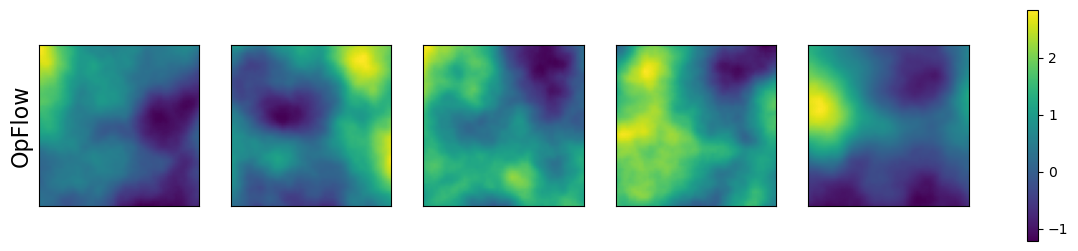

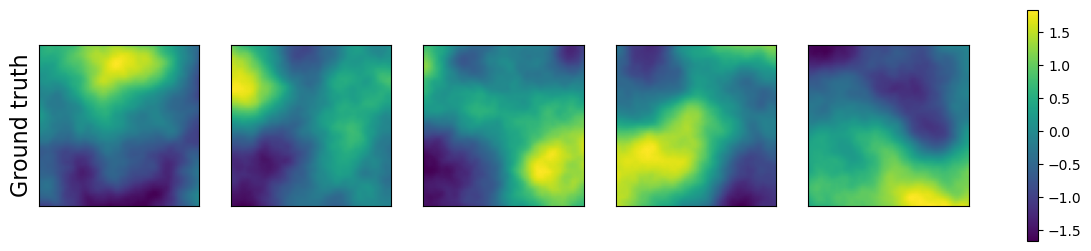

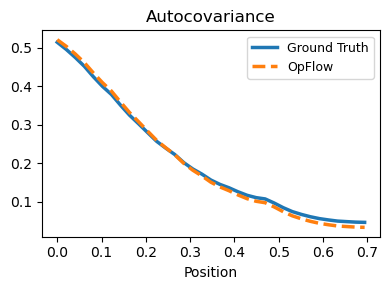

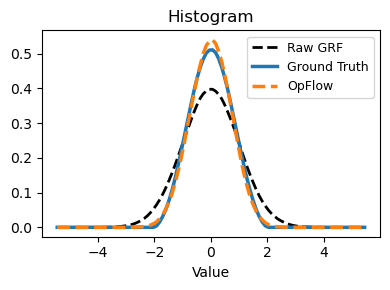

In [53]:
with torch.no_grad():
    Z = base_dist.rsample(sample_shape=(5,)).reshape(-1,ndim,ndim,1)
    X_hat = model.inverse(Z).detach().cpu().numpy()
    
    X_ground_truth = x_train[:5]
    Z_alt = base_dist.rsample(sample_shape=(5000,)).reshape(-1,ndim,ndim,1)

    z_train_iter = torch.split(Z_alt, 1000, dim=0)
    X_alt = []
    for i in range(len(z_train_iter)):
        z_train_temp = z_train_iter[i].to(device)
        x_alt = model.inverse(z_train_temp).detach().cpu()
        X_alt.append(x_alt)
        
    X_alt = torch.vstack(X_alt)        
    _, x_acovf = compute_acovf(X_alt.squeeze())
    x_hist, bin_edges_alt = X_alt.histogram(range=[-5.5,5.5], density=True)

    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat[i,:,:].squeeze()

        ax[i].imshow(x)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        if i == 0:
            ax[i].set_ylabel('OpFlow', fontsize=16)
        #ax[0].plot(x_ground_truth)
        #ax[0].set_title('Real')
        #ax[1].plot(x)
        #ax[1].set_title('OpFlow Generated')
        #ax[0].set_ylim([-3, 3])
        #ax[1].plot(sm.tsa.acovf(x, nlag=50))
        #ax[1].set_ylim([0.0, 1.0])

    #cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
    bar = ax[4].imshow(x)
    fig.colorbar(bar, ax=ax)

    #plt.show()
    #plt.savefig(f"../paper_pdf/{folder}/{folder}_opflow_samples.pdf")

    # covariance use position as x, adjust the size of histogram

    fig, ax = plt.subplots(1,5, figsize=(15,3))    
    for i in range(5):
        x_ground_truth = X_ground_truth[i,:,:].squeeze()
        ax[i].imshow(x_ground_truth)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        if i == 0:
            ax[i].set_ylabel('Ground truth', fontsize=16)
            
    bar = ax[4].imshow(x_ground_truth)
    fig.colorbar(bar, ax=ax)
    #plt.savefig(f"../paper_pdf/{folder}/{folder}_ground_truth.pdf")


    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot(x_pos, x_acovf_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot(x_pos, x_acovf,c='#ff7f0e', ls='--', lw=2.5, label='OpFlow')
    #ax.set_ylim(0,0.5)
    ax.set_title('Autocovariance')
    ax.set_xlabel('Position')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    plt.savefig(f"../paper_pdf/{folder}/{folder}_autocov.pdf")
    
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_raw,  c='k', lw=2, ls='--', label='Raw GRF')
    ax.plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true,  c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist, c='#ff7f0e', lw=2.5, ls='--',  label='OpFlow')
    ax.set_title('Histogram')
    ax.set_xlabel('Value')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    plt.savefig(f"../paper_pdf/{folder}/{folder}_statistic.pdf")
